In [ ]:
'''
This Jupyter Notebook implements a preprocessing pipeline for raw, multichannel
Local Field Potential (LFP) data recorded from crayfish. The pipeline iterates
through binary data files, applying a series of standard electrophysiological
processing steps to each channel. These steps include a 3-60 Hz band-pass
filter, a notch filter to remove 60 Hz line noise and its harmonics, ICA filtering,
and z-score normalization. Then it is segmented in epochs of 30 seconds. The processed,
clean data for each channel  is then saved as an individual .npy file, ready for further analysis.
'''

In [ ]:
# We import the tools we'll need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
#!pip install mne
import mne #EEG package (name for previous "Minimum Norm Estimation")

#### Step 0. Set the variables

In [ ]:
# We set the variables we will use (this should be modified based on need)

# Example: Processing one LFP window file
file_path = 'A338_control_2h.mat'

samfreq = 500 #sampling frequency
channel_names = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8']

# Filters
high_pass = 3.0
low_pass = 60.0
notch = 60.0

# Others
amp_thershold = 7.0 #thershold for artifact, ie value * SD
epoch_duration = 30 #in seconds


#### Step 1. Load data and MNE

In [ ]:
Load data and MNE
mat_file = loadmat(file_path) #this open the mat file as dict
keys = [key for key in mat_file.keys() if not key.startswith('__')] #chose the name inside the file
#lfp_data = data_dict[keys[0]]
data_numpy = mat_file[keys[0]] #extract the values of dict as numpy narray

data_numpy = data_numpy.T #to transpose because the MNE tool need (n_channels, n_samples)
#to check if correct order:
print(f"Transposed data to shape (channels, samples): {data_numpy.shape}")

# Create the MNE object
info = mne.create_info(ch_names = channel_names, sfreq = samfreq, ch_types='eeg') #metadate for the object
raw_data = mne.io.RawArray(data_numpy, info)


Transposed data to shape (channels, samples): (8, 1800000)
Creating RawArray with float64 data, n_channels=8, n_times=1800000
    Range : 0 ... 1799999 =      0.000 ...  3599.998 secs
Ready.


#### Step 2. Basic filtering

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Effective window size : 4.096 (s)


/tmp/ipython-input-3088961653.py:14: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum_raw.plot()


Plotting power spectral density (dB=True).


/tmp/ipython-input-3088961653.py:17: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum_filt.plot()


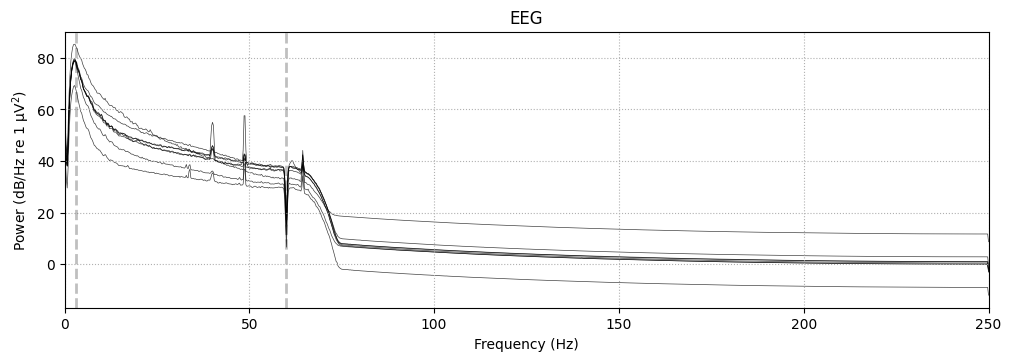

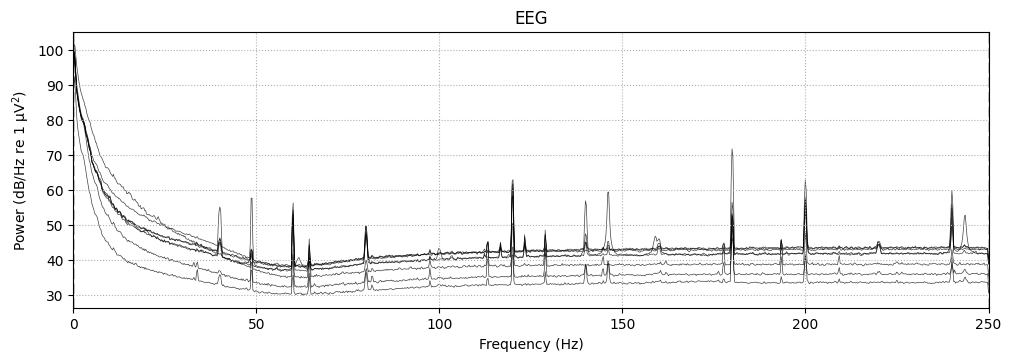

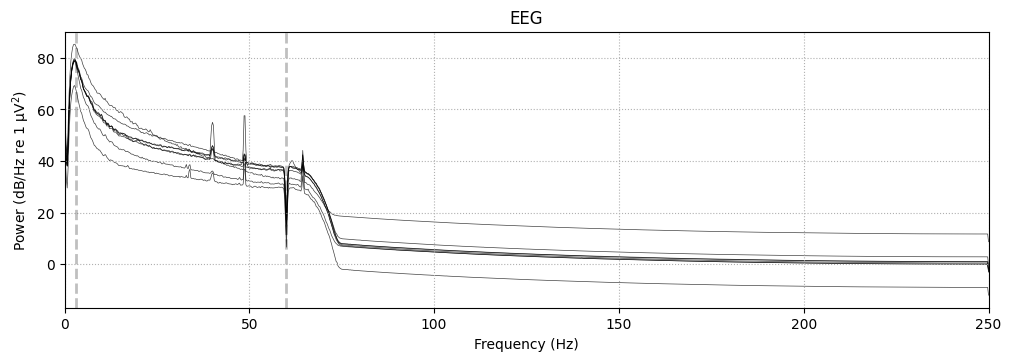

In [ ]:
# Basic filtering
raw_filtered = raw_data.copy() #to work with a copy if needed later

# Notch
notch_freqs = [60.0, 120.0, 180.0] #notch and harmonics
raw_filtered.notch_filter(freqs=notch_freqs, verbose=False)

# Band-pass filter
raw_filtered.filter(l_freq=high_pass, h_freq=low_pass, verbose=False)

# To check if filtering went OK
#print("Plotting the Power Spectral Density (PSD) to see the filter's effect")
spectrum_raw = raw_data.compute_psd()
spectrum_raw.plot()

spectrum_filt = raw_filtered.compute_psd()
spectrum_filt.plot()



#### Step 3. Detect and annotate artifacts

Found and annotated 1338 potential artifact points.
Plotting the first 5 minutes of data with artifacts marked in red...


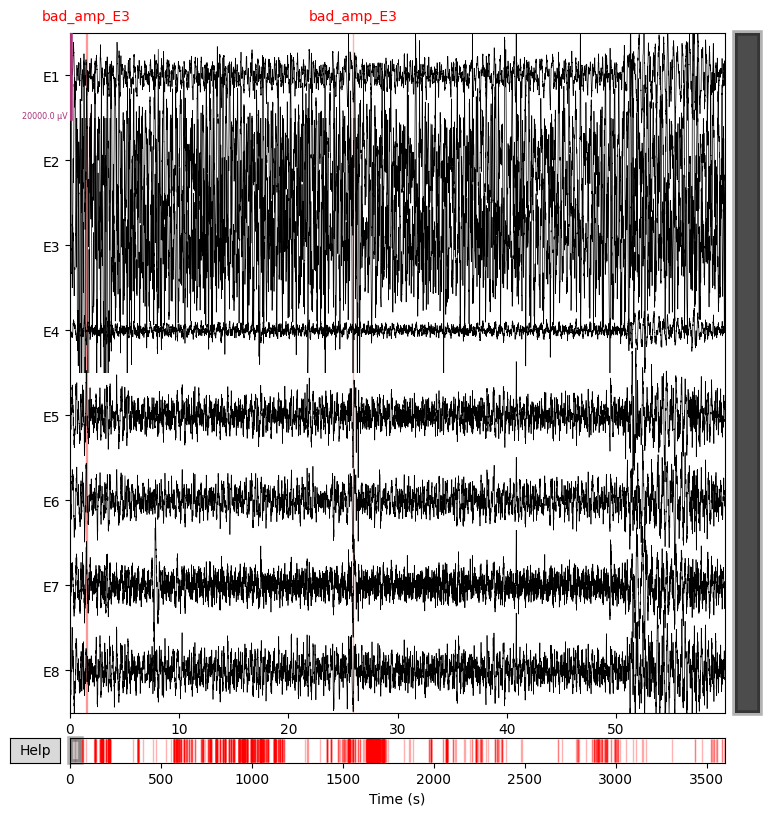

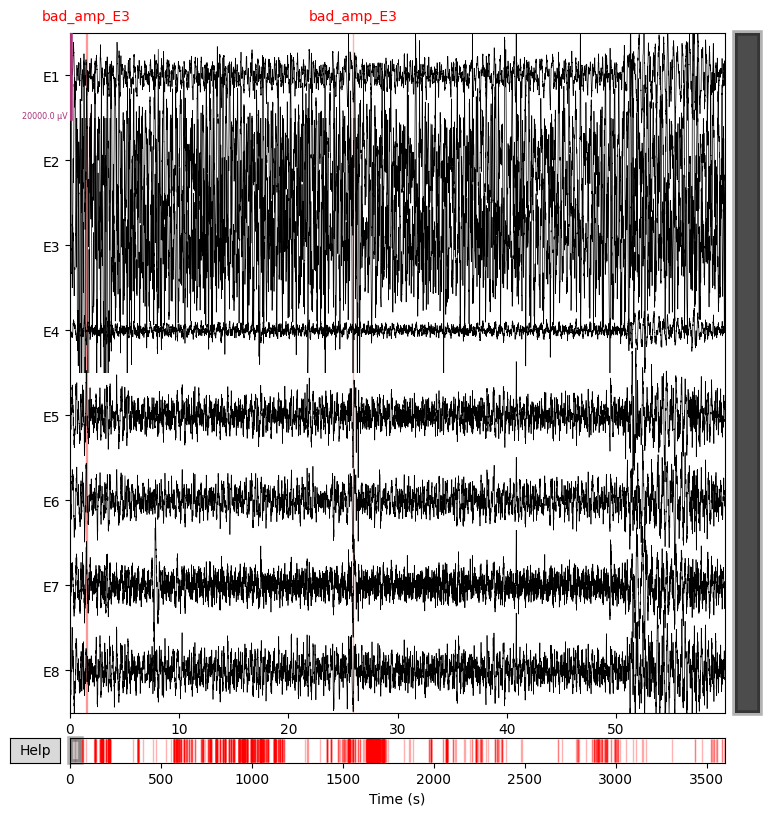

In [ ]:
# Detect and annotate artifacts
data_for_artifacts = raw_filtered.get_data() #extract the data as numpy
#For the threshold:
std_per_channel = np.std(data_for_artifacts, axis=1)
mean_std = np.mean(std_per_channel) #average std across all channels
amplitud_threshold = amp_thershold * mean_std #threshold, ie anything above = 'artifact'

artifact_annotations = [] #list to store the times and durations of each artifacts
for ind in range(len(channel_names)): #loop in each channel
  art_indices = np.where(np.abs(data_for_artifacts[ind, :]) > amplitud_threshold)[0]
  if len(art_indices) == 0:
    continue #skip channel if no artifacts
  breaks = np.where(np.diff(art_indices) > 1)[0] # if diff between 2 points > 1 then break
  #for continuos segments with artifacts:
  start_ind = np.insert(art_indices[breaks + 1], 0, art_indices[0])
  end_ind = np.append(art_indices[breaks], art_indices[-1])
  for start, end in zip(start_ind, end_ind):
    start_time = start / samfreq
    duration = (end - start + 1) / samfreq
    artifact_annotations.append([start_time, duration, f'bad_amp_{channel_names[ind]}'])

# We create a MNE object to mark events in data
if artifact_annotations:
    onsets = [ann[0] for ann in artifact_annotations]
    durations = [ann[1] for ann in artifact_annotations]
    descriptions = [ann[2] for ann in artifact_annotations]
    annotations = mne.Annotations(onset=onsets, duration=durations, description=descriptions)
    # Set the annotations on our data object. MNE will now know which parts are "bad".
    raw_filtered.set_annotations(annotations)
    print(f"Found and annotated {len(artifact_annotations)} potential artifact points.")
else:
    print("No artifacts found based on the threshold.")

# To visialize the annotations
print("Plotting the first 5 minutes of data with artifacts marked in red...")
raw_filtered.plot(start=0, duration=60, n_channels=8, scalings=dict(eeg=1e-2))




#### Step 4. ICA

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Omitting 21529 of 1800000 (1.20%) samples, retaining 1778471 (98.80%) samples.
Selecting by number: 8 components
Fitting ICA took 23.4s.
Creating RawArray with float64 data, n_channels=8, n_times=1800000
    Range : 0 ... 1799999 =      0.000 ...  3599.998 secs
Ready.


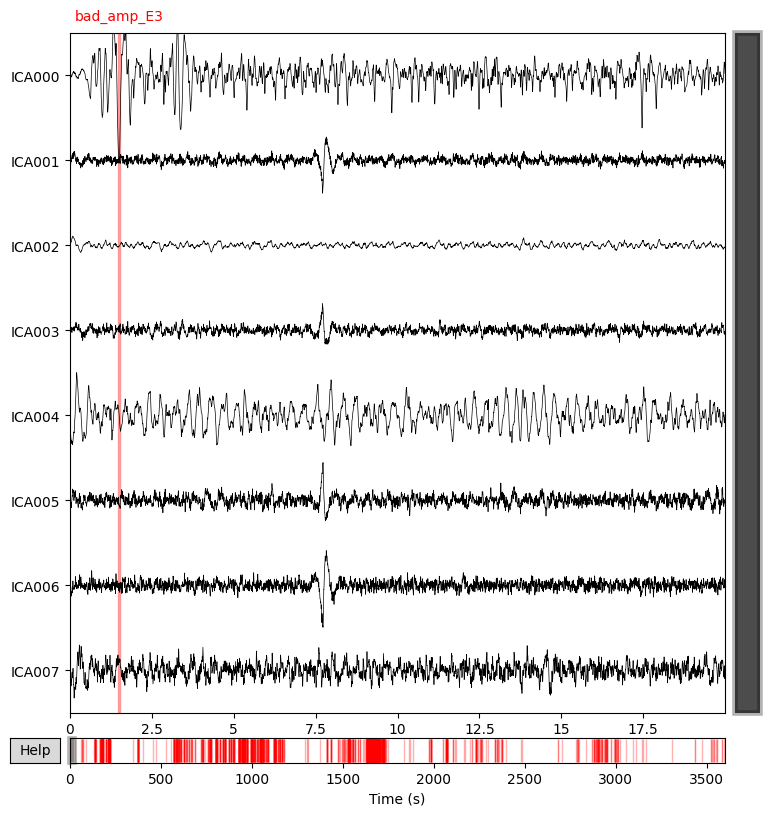

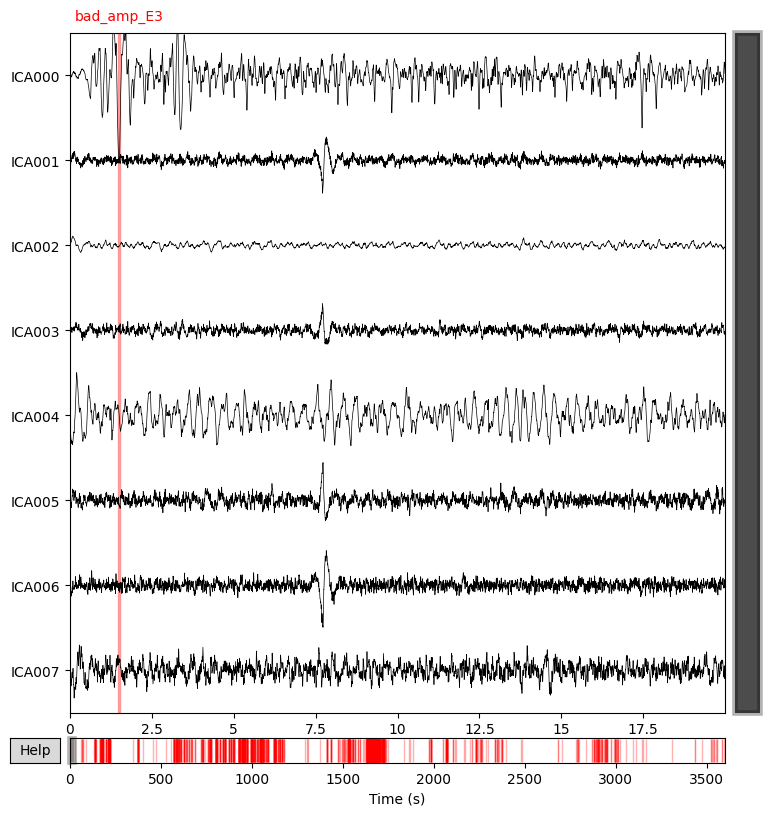

In [ ]:
# Perform ICA

from mne.preprocessing import ICA

ica = ICA(n_components=8, random_state=97, max_iter='auto')

ica.fit(raw_filtered, reject_by_annotation=True)

ica.plot_sources(raw_filtered)


In [ ]:
# To exclude the bad channels after inspection
ica.exclude = [0] #the specific channel to exclude

raw_ica_clean = raw_filtered.copy()

ica.apply(raw_ica_clean)

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


<RawArray | 8 x 1800000 (3600.0 s), ~109.9 MiB, data loaded>

#### Step 5. Re-referencing (common average reference)

In [ ]:
# Re-referencing (common average reference)

raw_rereferenced = raw_filtered.copy()

raw_rereferenced.set_eeg_reference('average', projection=True)

raw_rereferenced.apply_proj()

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<RawArray | 8 x 1800000 (3600.0 s), ~109.9 MiB, data loaded>

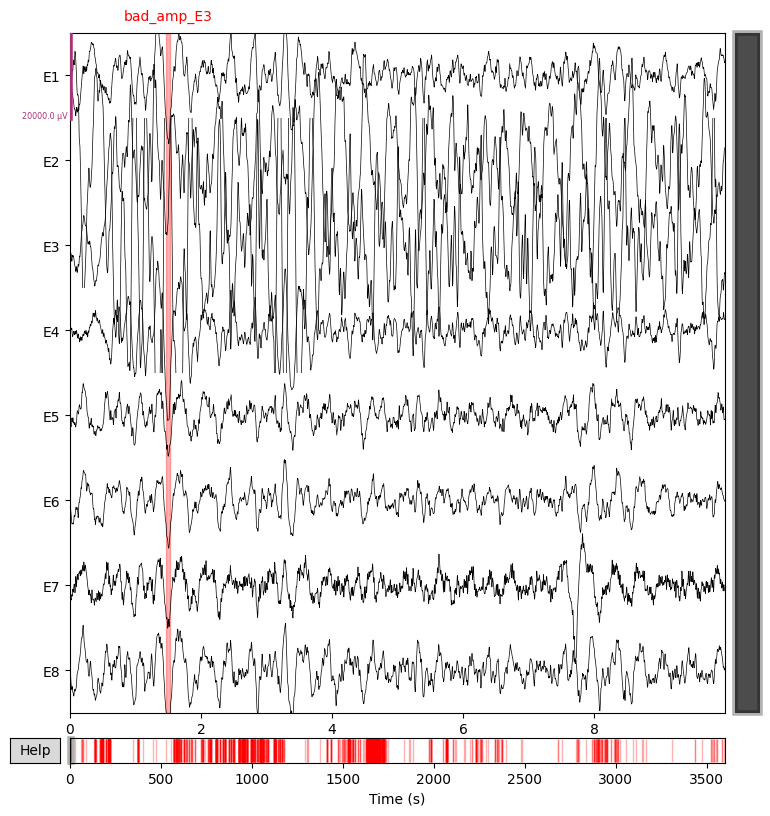

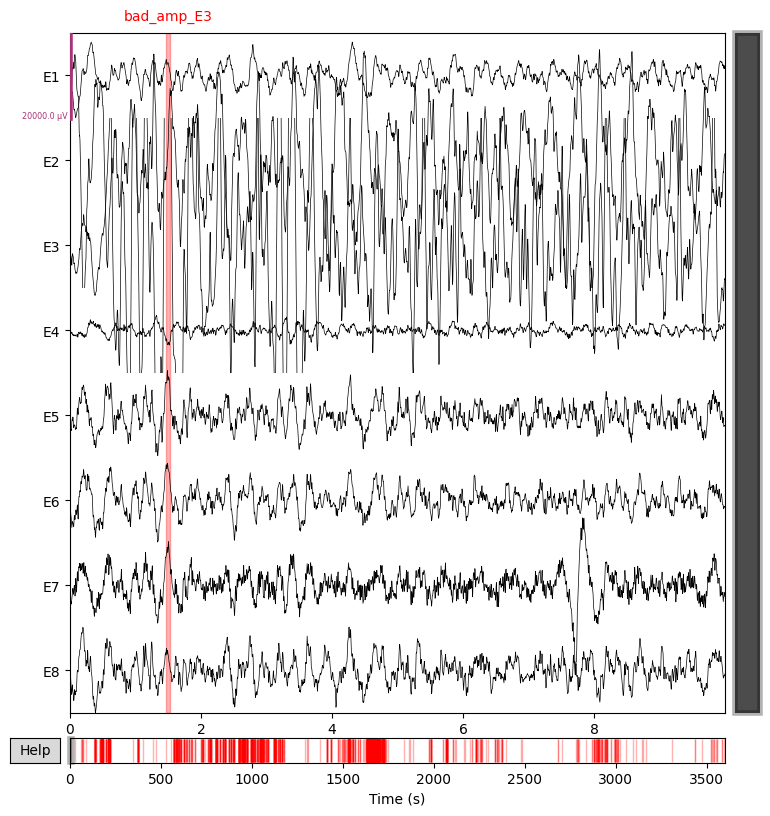

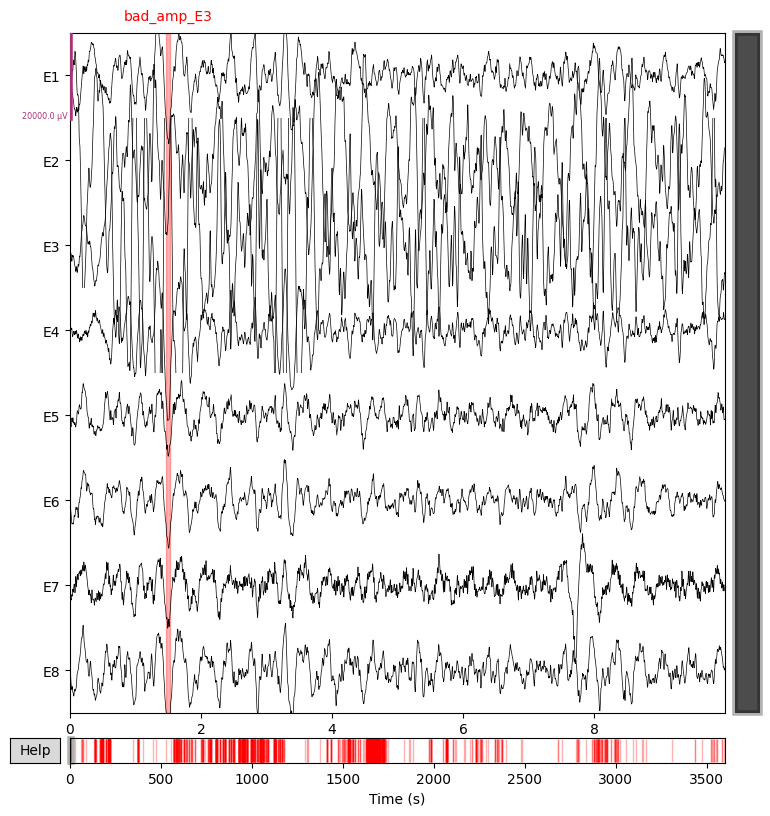

In [ ]:
#to visualize the effect:
# Plot the data before re-referencing
raw_filtered.plot(n_channels=8, scalings=dict(eeg=1e-2), show=False, title="Before CAR")
# Plot the data after re-referencing
raw_rereferenced.plot(n_channels=8, scalings=dict(eeg=1e-2), show=False, title="After CAR")


#### Step 6. Segmentation into epochs

In [ ]:
# Segmentation into epochs

events = mne.make_fixed_length_events(raw_rereferenced, duration=epoch_duration)

epochs = mne.Epochs(raw_rereferenced,
                    events,
                    tmin=0.,
                    tmax=epoch_duration - 1/samfreq, # Duration is tmax - tmin
                    baseline=(0, 0), # Add this line to fix the ValueError
                    reject_by_annotation=True, #automatically throws away bad epochs
                    preload=True,
                    verbose=True) # Set to True to see how many epochs were dropped

print(f"\nData has been segmented into {len(epochs)} clean epochs.")

final_data_array = epochs.get_data()
print(f"Your final data array is ready for analysis with shape: {final_data_array.shape}")

Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 120 events and 15000 original time points ...
83 bad epochs dropped

Data has been segmented into 37 clean epochs.
Your final data array is ready for analysis with shape: (37, 8, 15000)


#### Step 7. Save files

In [ ]:
# To save files
np.save('A338_control2_clean_epochs.npy', final_data_array)
print("Saved files")

Guardando las épocas limpias en 'clean_epochs_data.npy'...
¡Guardado completado!
